## Run all blocks together
1. Build a series of track and connect them
2. Plan path with specific policy
3. Plan velocity

In [182]:
import numpy as np
import cvxpy as cp
from scipy.interpolate import CubicSpline
import scipy.integrate as integrate
from scipy.sparse import csr_matrix
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## build real track and rotate them

In [151]:
class build_real_track:
    
    def __init__(self,W,kap_max,F,Len,psi_init = 0,pos_init = [0,0]):
        F1=F[0]
        F2=F[1]
        self.W = W
        self.kap_max = kap_max
        self.F = F
        self.Len = Len
        
        PX=[0,F2,1]
        PY=[0,kap_max,0]
        kap_intp = CubicSpline(PX,PY,bc_type=((1,0),(1,0)))
        xx=np.linspace(0,1,100)
        yy=kap_intp(xx)
        
        psi=integrate.cumtrapz(yy,xx*Len, initial=0)
    
        X = integrate.cumtrapz(np.cos(psi), xx*Len, initial=0)
        Y = integrate.cumtrapz(np.sin(psi), xx*Len, initial=0)
        [X_Left,Y_Left] = self.bias(X,Y,psi,W)
        [X_Right,Y_Right] = self.bias(X,Y,psi,-W)
        
        X_negative = np.linspace(-F1 * Len,0,100)
        X_positive = np.linspace(0, F1*Len, 100)
        Y_negative = np.zeros(100)
        
        self.S = np.hstack((X_positive[:-1], xx * Len +X_positive[-1]))
        Center_X = np.hstack((X_negative[:-1],X))
        Center_Y = np.hstack((Y_negative[:-1],Y))
        Left_X = np.hstack((X_negative[:-1],X_Left))
        Left_Y = np.hstack((Y_negative[:-1]+W,Y_Left))
        Right_X = np.hstack((X_negative[:-1],X_Right))
        Right_Y = np.hstack((Y_negative[:-1]-W,Y_Right))
        psi = np.hstack((Y_negative[:-1],psi))
        
        
        self.init_Center = [Center_X[0], Center_Y[0]]
        
        [self.Center_X, self.Center_Y] = self.rotate(psi_init, pos_init, Center_X, Center_Y)
        [self.Left_X , self.Left_Y] = self.rotate(psi_init, pos_init, Left_X, Left_Y)
        [self.Right_X, self.Right_Y] = self.rotate(psi_init, pos_init, Right_X, Right_Y)
        self.psi = np.unwrap(psi + psi_init)
        
        
    def bias(self,X,Y,psi,W):
        X2 = X - W * np.sin(psi)
        Y2 = Y + W * np.cos(psi)
        return X2,Y2
     
    def rotate(self,angle,pos, X, Y):
        X = X - self.init_Center[0]
        Y = Y - self.init_Center[1]
        X2 = np.cos(angle)*X - np.sin(angle)*Y + pos[0] 
        Y2 = np.cos(angle)*Y + np.sin(angle)*X + pos[1] 
        return X2,Y2

    def plot(self):
        plt.figure()
        plt.plot(self.Center_X,self.Center_Y,'k')
        plt.plot(self.Left_X,self.Left_Y,'b--')
        plt.plot(self.Right_X,self.Right_Y,'r--')
        
        plt.axis('equal')
        plt.show()
    
    def plot2(self):
        
        plt.plot(self.Center_X,self.Center_Y,'k')
        plt.plot(self.Left_X,self.Left_Y,'b--')
        plt.plot(self.Right_X,self.Right_Y,'r--')
    
    

In [167]:
track_param= {
    'num' : 4,
    'W' : np.array([3.5,3.5,3.5,3.5]),
    'kap_max' : np.array([0.01,-0.015,0.02,0.015]),
    'F' : np.array([[0.7,0.3],[0.2,0.4],[0.2,0.6],[0.3,0.7]]),
    'Len' : np.array([80,60,70,80])
}

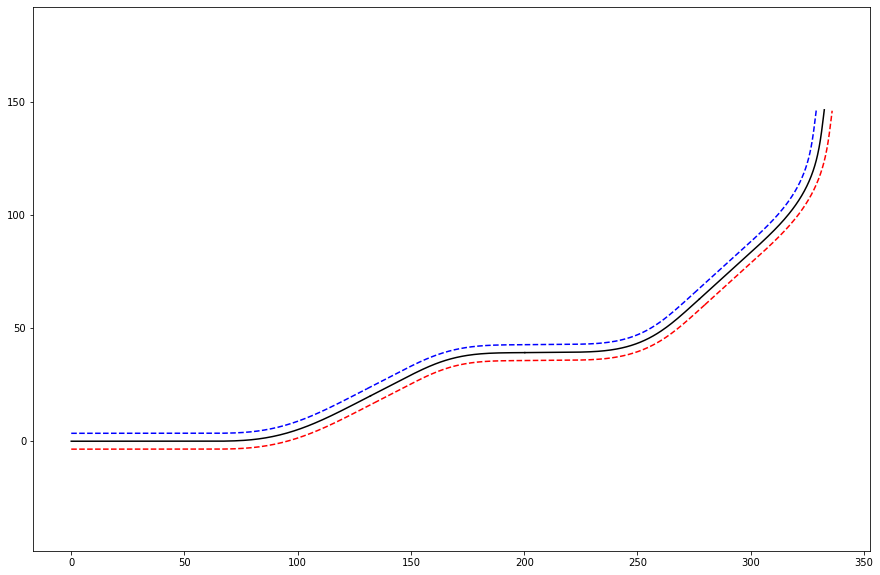

In [168]:
track = {}
for i in range(track_param['num']):
    if i > 0:
        psi_init = track[i-1].psi[-1]
        pos_init = [track[i-1].Center_X[-1], track[i-1].Center_Y[-1]]
    else:
        psi_init, pos_init = 0, [0,0]
           
    track[i] = build_real_track(W = track_param['W'][i], kap_max =track_param['kap_max'][i], 
                                F =track_param['F'][i] ,Len =track_param['Len'][i],
                                psi_init = psi_init, pos_init = pos_init)

plt.figure(figsize=(15,10))
for i in range(track_param['num']):
    track[i].plot2()
    
plt.axis('equal')
plt.show()

## build standard track, path and policy

In [171]:
class build_track:
    def __init__(self,F):
        num=200
        F1=F[0]
        F2=F[1]
        self.Center_X=np.linspace(-F1,1,num)
        self.Center_Y=np.linspace(0,0,num)
        
        self.WL=0.1
        self.WR=0.1
        
        self.Left_X=self.Center_X
        self.Left_Y=np.linspace(1,1,num)*self.WL
        
        self.Right_X=self.Center_X
        self.Right_Y=np.linspace(-1,-1,num)*self.WR
        
class build_path:
    def __init__(self,F,P,T):
        F1=F[0]
        F2=F[1]
        self.PX=np.array([-F1,0,F2,1])
        self.PY=P*T.WL
        self.S=np.array([0,F1,F1+F2,F1+1])
        self.WL=T.WL
        self.WR=T.WR
        self.track=T

        self.len=F1+1
        self.Vx=0.01
        self.Np=int(np.floor(self.len/self.Vx))+1
        self.Ns=2
        self.Nc=1
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        self.ind_Y=np.arange(Np)*Ns
        self.ind_Vy=1+np.arange(Np)*Ns
        self.ind_ay=Np*Ns+np.arange(Np-1)*Nc
        
        self.X=np.linspace(-F1,1,Np)

        # parameters of constraints
        self.Q=np.array([0,1])
        self.R=np.array([100.0])
        ind=np.floor(self.S/self.Vx)
        self.ind=np.array([int(i) for i in ind])

#          # ***********build sequential state space A_qp*x=b_qp******
        self.Ac=np.array([[0,1],[0,0] ])
        self.Bc=np.array([[0],[1]])
        self.Ad=np.eye(Ns)+self.Ac
        self.Bd=self.Bc

        # dynamics model      
        A_combined1=np.zeros(((Np-1)*Ns,Np*Ns))
        A_combined2=np.zeros(((Np-1)*Ns,(Np-1)*Nc))
        
        for index in range(Np-1):
            ind1=index*Ns+np.arange(Ns)
            ind2x=index*Ns+np.arange(Ns)
            ind2I=ind2x+Ns
            ind2u=index*Nc+np.arange(Nc)
            
            A_combined1[np.ix_(ind1,ind2I)]=np.eye(Ns)
            A_combined1[np.ix_(ind1,ind2x)]=-self.Ad
            A_combined2[np.ix_(ind1,ind2u)]=-self.Bd
            
        self.A_qp=np.hstack((A_combined1,A_combined2))
        self.b_qp=np.zeros(((Np-1)*Ns))
        
        # bnd
        Gx=csr_matrix((np.ones(Np),(np.arange(Np),self.ind_Y)),
                     shape=(Np,Np*Ns+(Np-1)*Nc)).toarray()
        self.G_qp=np.vstack((Gx,-Gx))

        hx=np.ones((Np,1))*self.WL
        self.h_qp=np.vstack((hx,hx))

        
        Q_w=np.tile(self.Q,(1,Np))
        R_w=np.tile(self.R,(1,Np-1))
        
        self.Q_qp=np.diag(np.hstack((Q_w,R_w))[0])
        self.P_qp=np.zeros((self.Q_qp.shape[0],1))
        
                             
    def generate(self):
        
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        num_PY=self.PY.shape[0]

       
        Ax=csr_matrix((np.ones(num_PY),(np.arange(num_PY),self.ind*Ns)),
                     shape=(num_PY,(Np)*Ns+(Np-1)*Nc)).toarray()
            
        bx=self.PY
        

        x=cp.Variable((Np*Ns+(Np-1)*Nc))
        cost=cp.quad_form(x,self.Q_qp)
                      
        constraints=[]
        constraints+=[self.A_qp@x==self.b_qp]
        constraints+=[Ax@x==self.PY]
        
        # initial & end angle ==0
        constraints+=[x[self.ind_Vy[0]]==0]
        constraints+=[x[self.ind_Vy[-1]]==0]
        
        # boundary
        constraints+=[x[self.ind_Y]>=-np.ones(Np)*self.WR,
                     x[self.ind_Y]<=np.ones(Np)*self.WL]
        
        prob=cp.Problem(cp.Minimize(cost),constraints)
        prob.solve()
        
     
        self.Y=x[self.ind_Y].value
        self.Vy=x[self.ind_Vy].value
        self.ay=x[self.ind_ay].value
        
        
    def plot(self):
        track=self.track
        path=self

        f=plt.figure()

        plt.plot(track.Center_X,track.Center_Y,'b--')
        plt.plot(track.Left_X,track.Left_Y,'b')
        plt.plot(track.Right_X,track.Right_Y,'b')
        plt.plot(path.X,path.Y,'k.')
        plt.plot(path.PX,path.PY,'ro')

        plt.axis('equal')

        np.max(np.abs(path.PY))

        f2=plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(path.Vy)

        plt.subplot(1,2,2)
        plt.plot(path.ay)

# F and P

class build_feature:
    
    def __init__(self):
        self.num_F=10
        self.num_P=20
        self.num_seg=3
        self.bnd=0.1
        self.total_num_F=self.num_F**(self.num_seg-1)
        self.total_num_P=self.num_P**(self.num_seg+1)
        
        # build F shape tuple
        self.size_F=()
        for i in range(self.num_seg-1):
            self.size_F+=(self.num_F,)
        
        # build P shape tuple
        self.size_P=()
        for i in range(self.num_seg+1):
            self.size_P+=(self.num_P,)

        # build F space
        self.space_F=np.linspace(0+self.bnd,1-self.bnd,self.num_F)
        
        # build P space
        self.space_P=np.linspace(-1,1,self.num_P)

    def fetch_feature_F(self,ind_F):
        
        sub_F = np.array(list(np.unravel_index(ind_F,self.size_F)))
        self.F = np.array([self.space_F[i] for i in sub_F])
        
    def fetch_feature_P(self,ind_P):
        
        sub_P = np.array(list(np.unravel_index(ind_P,self.size_P)))
        self.P = np.array([self.space_P[i] for i in sub_P])

## build real path

In [213]:
class build_real_path:
    
    def retrive_standard_path(self,F,P,path):
        F1=F[0]
        F2=F[1]
        
        self.S_std = np.linspace(0,1+F1,path.shape[0])
        self.X_std = np.linspace(-F1,1,path.shape[0])
        self.Y_std = path
    
    def retrive_real_path(self,T):
        self.T = T  
        s_extend = self.S_std * T.Len
        Y_extend = self.Y_std * T.W * 10
        
        T_X_intp = CubicSpline(T.S,T.Center_X)
        T_Y_intp = CubicSpline(T.S,T.Center_Y)
        T_psi_intp = CubicSpline(T.S,T.psi)
        
        T_X = T_X_intp(s_extend)
        T_Y = T_Y_intp(s_extend)
        T_psi = T_psi_intp(s_extend)
        
        [self.X, self.Y] = self.bias(T_X,T_Y,T_psi,Y_extend)
        self.Center_S = s_extend
        

    def bias(self,X,Y,psi,W):
        X2 = X - W * np.sin(psi)
        Y2 = Y + W * np.cos(psi)
        return X2,Y2
        
    def get_kap(self):
        arr = np.linspace(0,self.X.shape[0],self.X.shape[0])
        X_intp = CubicSpline(arr,self.X)
        Y_intp = CubicSpline(arr,self.Y)
        
        X = X_intp(arr)
        Y = Y_intp(arr)
        dX = X_intp(arr,1)
        dY = Y_intp(arr,1)
        d2X = X_intp(arr,2)
        d2Y = Y_intp(arr,2)
        
        self.ds = np.sqrt(dX**2+dY**2)
        self.psi = np.arctan2(dY,dX)
        self.kap = (dX*d2Y-dY*d2X)/(dX**2+dY**2)**1.5
        self.kap_average = np.average(abs(self.kap))
        self.S = integrate.cumtrapz(self.ds,initial=0)
    
    def get_velocity(self, V_init, ay_max, ax_max, ax_min):
        
        kap = np.abs(self.kap) + 1.0e-10
        ds = self.ds
        num = kap.shape[0]
        V0 = np.ones(num) * 1.0
        V1 = np.empty(num)
        V2 = np.empty(num)
        
        
        threshold = 0.01
        flag = 1
        t0 = 0
        
        
        while flag ==1:
        
            # rest of ay
            ay_rest = np.sqrt(ay_max**2 - V0**2*kap)

            # maximum of V
            V_max = np.sqrt(ay_rest/kap)

            # forward
            V1[0] = V_init
            for i in range(num-1):
                V1[i+1] = min(V_max[i+1] , np.sqrt(2*ax_max*ds[i] + V1[i]**2))

            # backward
            V2[-1] = V_max[-1]
            for i in range(num-1,0,-1):
                V2[i-1] = min(V_max[i-1] , np.sqrt(-2*ax_min*ds[i-1] + V2[i]**2))

            V_m = np.amin(np.vstack((V1,V2)),axis=0)
            V0 = (V_m+V0)/2
            t1 = np.sum(ds/V0)
            
            
            if np.abs(t1-t0) < threshold:
                flag = 0
            t0 = t1

        
        self.laptime = t0
        self. V_exit = V0[-1]
        
        # plt.figure(figsize=(10,10))
        # plt.plot(V_max,'k--')
        # plt.plot(V1,'b--')
        # plt.plot(V2,'r--')
        # plt.plot(V0)
        
    
    def plot(self):
        
        plt.figure(figsize=(17,7))
        plt.plot(self.T.Center_X,self.T.Center_Y,'k--')
        plt.plot(self.T.Left_X,self.T.Left_Y,'b--')
        plt.plot(self.T.Right_X,self.T.Right_Y,'r--')
        
        plt.plot(self.X,self.Y,'k')
        
        plt.axis('equal')
        plt.show()
        
        plt.plot(self.kap)

In [219]:
std_track = {}
for i in range(track_param['num']):
    std_track[i] = build_track(track_param['F'][i])

init_bias = -0.4
# policy = np.array([0.0,0.8,-0.9,0.8])
# path=build_path(track_param['F'][0], policy, std_track[0])
# path.generate()

# real_path = build_real_path()
# real_path.retrive_standard_path(F=track_param['F'][0], P=policy, path=path.Y)
# real_path.retrive_real_path(track[0])
# real_path.get_kap()
# real_path.get_velocity(V_init=35, ay_max=10.0, ax_max=1.3, ax_min=-9.5)

## main frame of graph search

In [221]:
# use binary seraching

# initial policy
num_sample=5
num_pts=3

bnd=np.tile(np.array([-1.0,1.0]),(num_pts,1))

# policies=np.tile(np.linspace(-1,1,num_sample),(num_pts,1))


size_policy=()
for i in range(num_pts):
    size_policy+=(num_sample,)

policy_lib=np.array(list(np.unravel_index(
                np.arange(num_sample**num_pts),size_policy)))

# binary loop
for iter_binary in range(5):
    # fetch policies
    policies=[np.linspace(bnd[i][0],bnd[i][1],num_sample) for i in range(num_pts)]
    
    # policy loop
    total_iter = num_sample**num_pts
    sv = {'time':np.empty(total_iter), 'V_exit':np.empty(total_iter), 'kap_average':np.empty(total_iter)}
    for iter_policy in tqdm(range(total_iter)):
        
        # select policy
        policy=np.array([policies[i][policy_lib[i][iter_policy]] for i in range(num_pts)])
        
# TODO: 
        
        path=build_path(track_param['F'][0], np.hstack(([init_bias],policy)), std_track[0])
        path.generate()
        real_path = build_real_path()
        real_path.retrive_standard_path(F=track_param['F'][0], P=policy, path=path.Y)
        real_path.retrive_real_path(track[0])
        real_path.get_kap()
        real_path.get_velocity(V_init=35, ay_max=10.0, ax_max=1.3, ax_min=-9.5)
        
        sv['time'][iter_policy] = real_path.laptime
        sv['V_exit'][iter_policy] = real_path.V_exit
        sv['kap_average'][iter_policy] = real_path.kap_average
# TODO:
    # calculate F and H(using the distance of next corner)  
    # then select the best policy
    
#     best_iter = random.randint(0,num_sample**num_pts)
    best_iter = np.argmin(sv['time'])
    best_index=[policy_lib[i][best_iter] for i in range(num_pts)]

# replan the policies with binary method

    for i in range(num_pts):
        
        bnd[i][0]=policies[i][max(best_index[i]-1,0)]
        bnd[i][1]=policies[i][min(best_index[i]+1,num_sample-1)]
    

    
policy_finally=[policies[i][best_index[i]] for i in range(num_pts)]



100%|██████████| 125/125 [00:45<00:00,  2.78it/s]


72


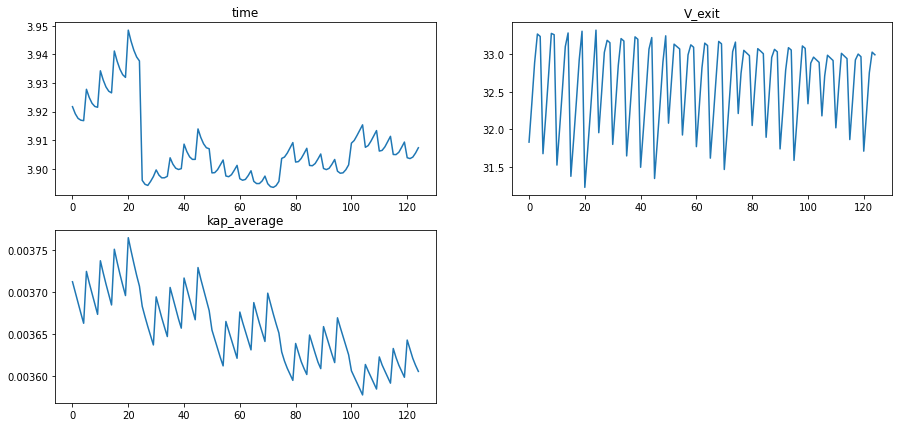

In [230]:
print(best_iter)
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(sv['time'])
plt.title('time')

plt.subplot(2,2,2)
plt.plot(sv['V_exit'])
plt.title('V_exit')

plt.subplot(2,2,3)
plt.plot(sv['kap_average'])
plt.title('kap_average')

plt.show()

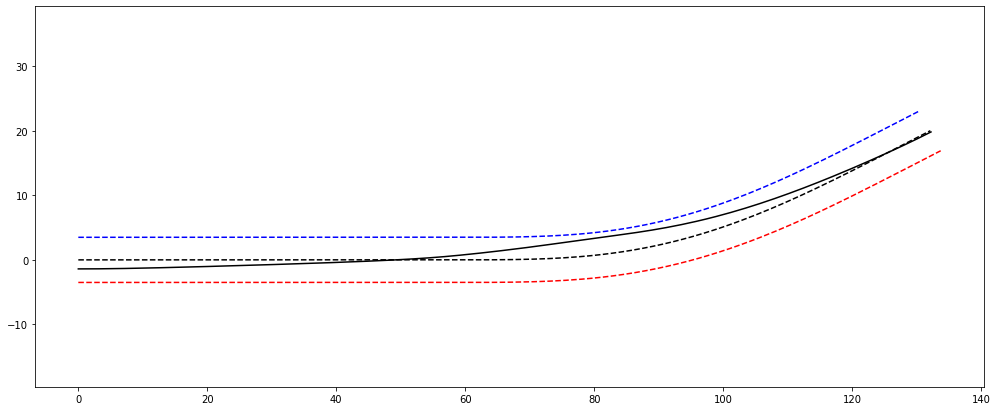

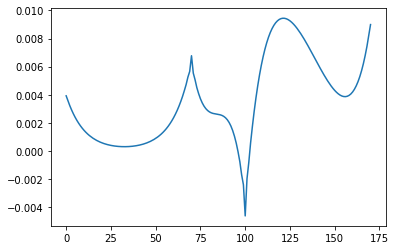

In [223]:
policy = np.hstack(([init_bias],policy_finally))


# policy = np.array([0.0,0.8,-0.9,0.8])
path=build_path(track_param['F'][0], policy, std_track[0])
path.generate()

real_path = build_real_path()
real_path.retrive_standard_path(F=track_param['F'][0], P=policy, path=path.Y)
real_path.retrive_real_path(track[0])
real_path.get_kap()
real_path.get_velocity(V_init=35, ay_max=10.0, ax_max=1.3, ax_min=-9.5)

real_path.plot()

In [224]:
policy

array([-0.4   ,  0.125 ,  0.75  , -0.0625])